In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 23.5 MB/s 


In [ ]:
import numpy as np 
import pandas as pd 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import LeakyReLU
import cv2
from tqdm import tqdm
import random
import math
from tensorflow.keras.utils import to_categorical  

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input,VGG16
vgg=VGG16(include_top=False, pooling='avg', weights='imagenet', input_shape=(178, 218, 3))

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
EPOCHS = 70
BATCH_SIZE = 32

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/shprjct/age_gender.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


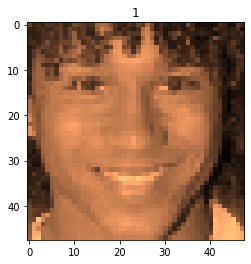

In [ ]:
index = 5000
image = np.fromstring(df['pixels'][index], sep = ' ', dtype = np.uint8).reshape((48,48))
plt.title(df['ethnicity'][index])
plt.imshow(image, cmap ="copper")
plt.show()   # to generate image from the pixels this block of code we are using 

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size = 32,
                 input_size=(48, 48, 3),
                 shuffle=True,
                 data_augmentation = False):
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.data_augmentation = data_augmentation
        self.var = 1
        
        self.imageGenerator = ImageDataGenerator(
            horizontal_flip = True,
            #vertical_flip = True,
            fill_mode = 'nearest',
            zoom_range = (1, 1.1),
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            rotation_range = 10
        )
        
        self.images = []
        self.age_labels = []        
        self.ethnicity_labels = []
        self.gender_labels = []    # these 4 lines is the label defining
        
        for index, row in tqdm(df.iterrows()):
            image = np.fromstring(row['pixels'], sep = ' ', dtype = np.uint8).reshape((48,48))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            self.images.append(image)
            
            self.age_labels.append(row['age'])
            self.ethnicity_labels.append(row['ethnicity'])
            self.gender_labels.append(row['gender'])           # this for loop is for the appending of labels to those particular images
            
            
        self.images = np.array(self.images)
        self.age_labels = np.array(self.age_labels).astype(np.float32)
        self.ethnicity_labels = np.array(self.ethnicity_labels).astype(np.float32)
        self.gender_labels = np.array(self.gender_labels).astype(np.float32)
        
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = to_categorical(self.ethnicity_labels[p], num_classes=5)
        self.gender_labels = self.gender_labels[p]
        
        self.n = len(self.df)
        
    
    def __getitem__(self, index):
        images = []
        
        for i in range(self.batch_size):
            image = self.images[index * self.batch_size + i]
            
            if self.data_augmentation:                
                image = self.imageGenerator.random_transform(image)
                
            images.append(image)                  
            
        s = slice(self.batch_size * index, (index + 1) * self.batch_size)
        return np.array(images), (self.age_labels[s], self.ethnicity_labels[s], self.gender_labels[s])
    
    def __len__(self):
            
        return self.n // self.batch_size
    
    def on_epoch_end(self):
        
        #Random permutation
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = self.ethnicity_labels[p]
        self.gender_labels = self.gender_labels[p]

In [ ]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
val = df[~msk]

train_dataset = CustomDataGen(train, data_augmentation = True)
val_dataset = CustomDataGen(val)

18925it [00:06, 2726.66it/s]
4780it [00:01, 2899.79it/s]


237
26.0 [0. 0. 0. 1. 0.] 0.0


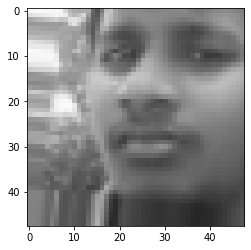

In [ ]:
train_dataset.on_epoch_end()
x, y = train_dataset[420]
print(x[21].max())
print(y[0][0], y[1][0], y[2][0])
plt.imshow(x[0])

In [ ]:
def build_model(input_shape = (48,48,3)):
    
    i = tf.keras.layers.Input(input_shape, dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    
    backbone = tf.keras.applications.vgg16.VGG16(
                include_top=False, weights='imagenet',
                input_tensor=x
            )
    output_layer = backbone.get_layer("block5_conv3").output    
    
    
    def build_age_branch(input_tensor): 
        x = tf.keras.layers.Dense(1024, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = None, name = 'age_output')(x)
    
        return x
    
  """def build_etchnicity_branch(input_tensor): 
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(5, activation = 'softmax', name = 'ethnicity_output')(x)
    
        return x"""
        
    
    def build_gender_branch(input_tensor): 
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'gender_output')(x)
    
        return x
    
    x = tf.keras.layers.Flatten()(output_layer)       
    output_age = build_age_branch(x)
    # output_ethnicity = build_etchnicity_branch(x)
    output_gender = build_gender_branch(x)
    model = tf.keras.Model(i, [output_age, output_ethnicity, output_gender])
    
    return model

In [ ]:
model = build_model()

Epoch 1/70
591/591 [==============================] - 47s 50ms/step - loss: 1.9425 - age_output_loss: 1189.6576 - ethnicity_output_loss: 1.0606 - gender_output_loss: 0.4451 - age_output_accuracy: 0.0011 - ethnicity_output_accuracy: 0.6317 - gender_output_accuracy: 0.7992 - val_loss: 1.1264 - val_age_output_loss: 358.2922 - val_ethnicity_output_loss: 0.9803 - val_gender_output_loss: 0.5559 - val_age_output_accuracy: 0.0052 - val_ethnicity_output_accuracy: 0.6728 - val_gender_output_accuracy: 0.8217 - lr: 1.0000e-04
Epoch 2/70
591/591 [==============================] - 30s 51ms/step - loss: 1.3799 - age_output_loss: 817.8336 - ethnicity_output_loss: 0.7962 - gender_output_loss: 0.3279 - age_output_accuracy: 6.8739e-04 - ethnicity_output_accuracy: 0.7346 - gender_output_accuracy: 0.8629 - val_loss: 1.1970 - val_age_output_loss: 656.1648 - val_ethnicity_output_loss: 0.8273 - val_gender_output_loss: 0.2544 - val_age_output_accuracy: 0.0015 - val_ethnicity_output_accuracy: 0.7366 - val_gende

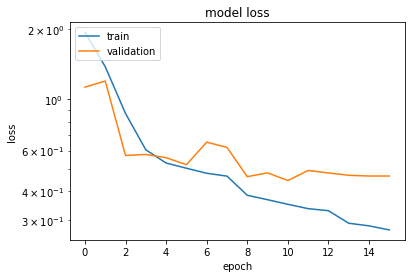

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss = ['mse', 'categorical_crossentropy', 'binary_crossentropy'], loss_weights = [0.001,0.5,0.5], 
              metrics = {'age_output': 'accuracy', 'ethnicity_output': 'accuracy', 'gender_output': 'accuracy'})

plateau = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=2, verbose = 1
)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                      patience=5)  # Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True,
                                            mode='min', save_weights_only = True)  # Saves the best version of the model to disk (as measured on the validation data set)
remote_monitor_callback = tf.keras.callbacks.RemoteMonitor(
    root='https://dweet.io', path='/dweet/for/multitask',
    send_as_json=False, field = 'data'
)     

history = model.fit(train_dataset,
            epochs=EPOCHS,
            batch_size = BATCH_SIZE,
            validation_data=val_dataset,
            callbacks = [es, save_best, plateau, remote_monitor_callback])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale('log')
plt.show()

In [ ]:
model.load_weights('weights.h5')
model.evaluate(val_dataset)
model.summary()

149/149 [==============================] - 2s 15ms/step - loss: 0.4449 - age_output_loss: 66.6336 - ethnicity_output_loss: 0.5490 - gender_output_loss: 0.2075 - age_output_accuracy: 0.0419 - ethnicity_output_accuracy: 0.8207 - gender_output_accuracy: 0.9199
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 tf.cast (TFOpLambda)           (None, 48, 48, 3)    0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 48, 48, 3)   0           ['tf.cast[0][0]']                
 ingOpLambda)                     

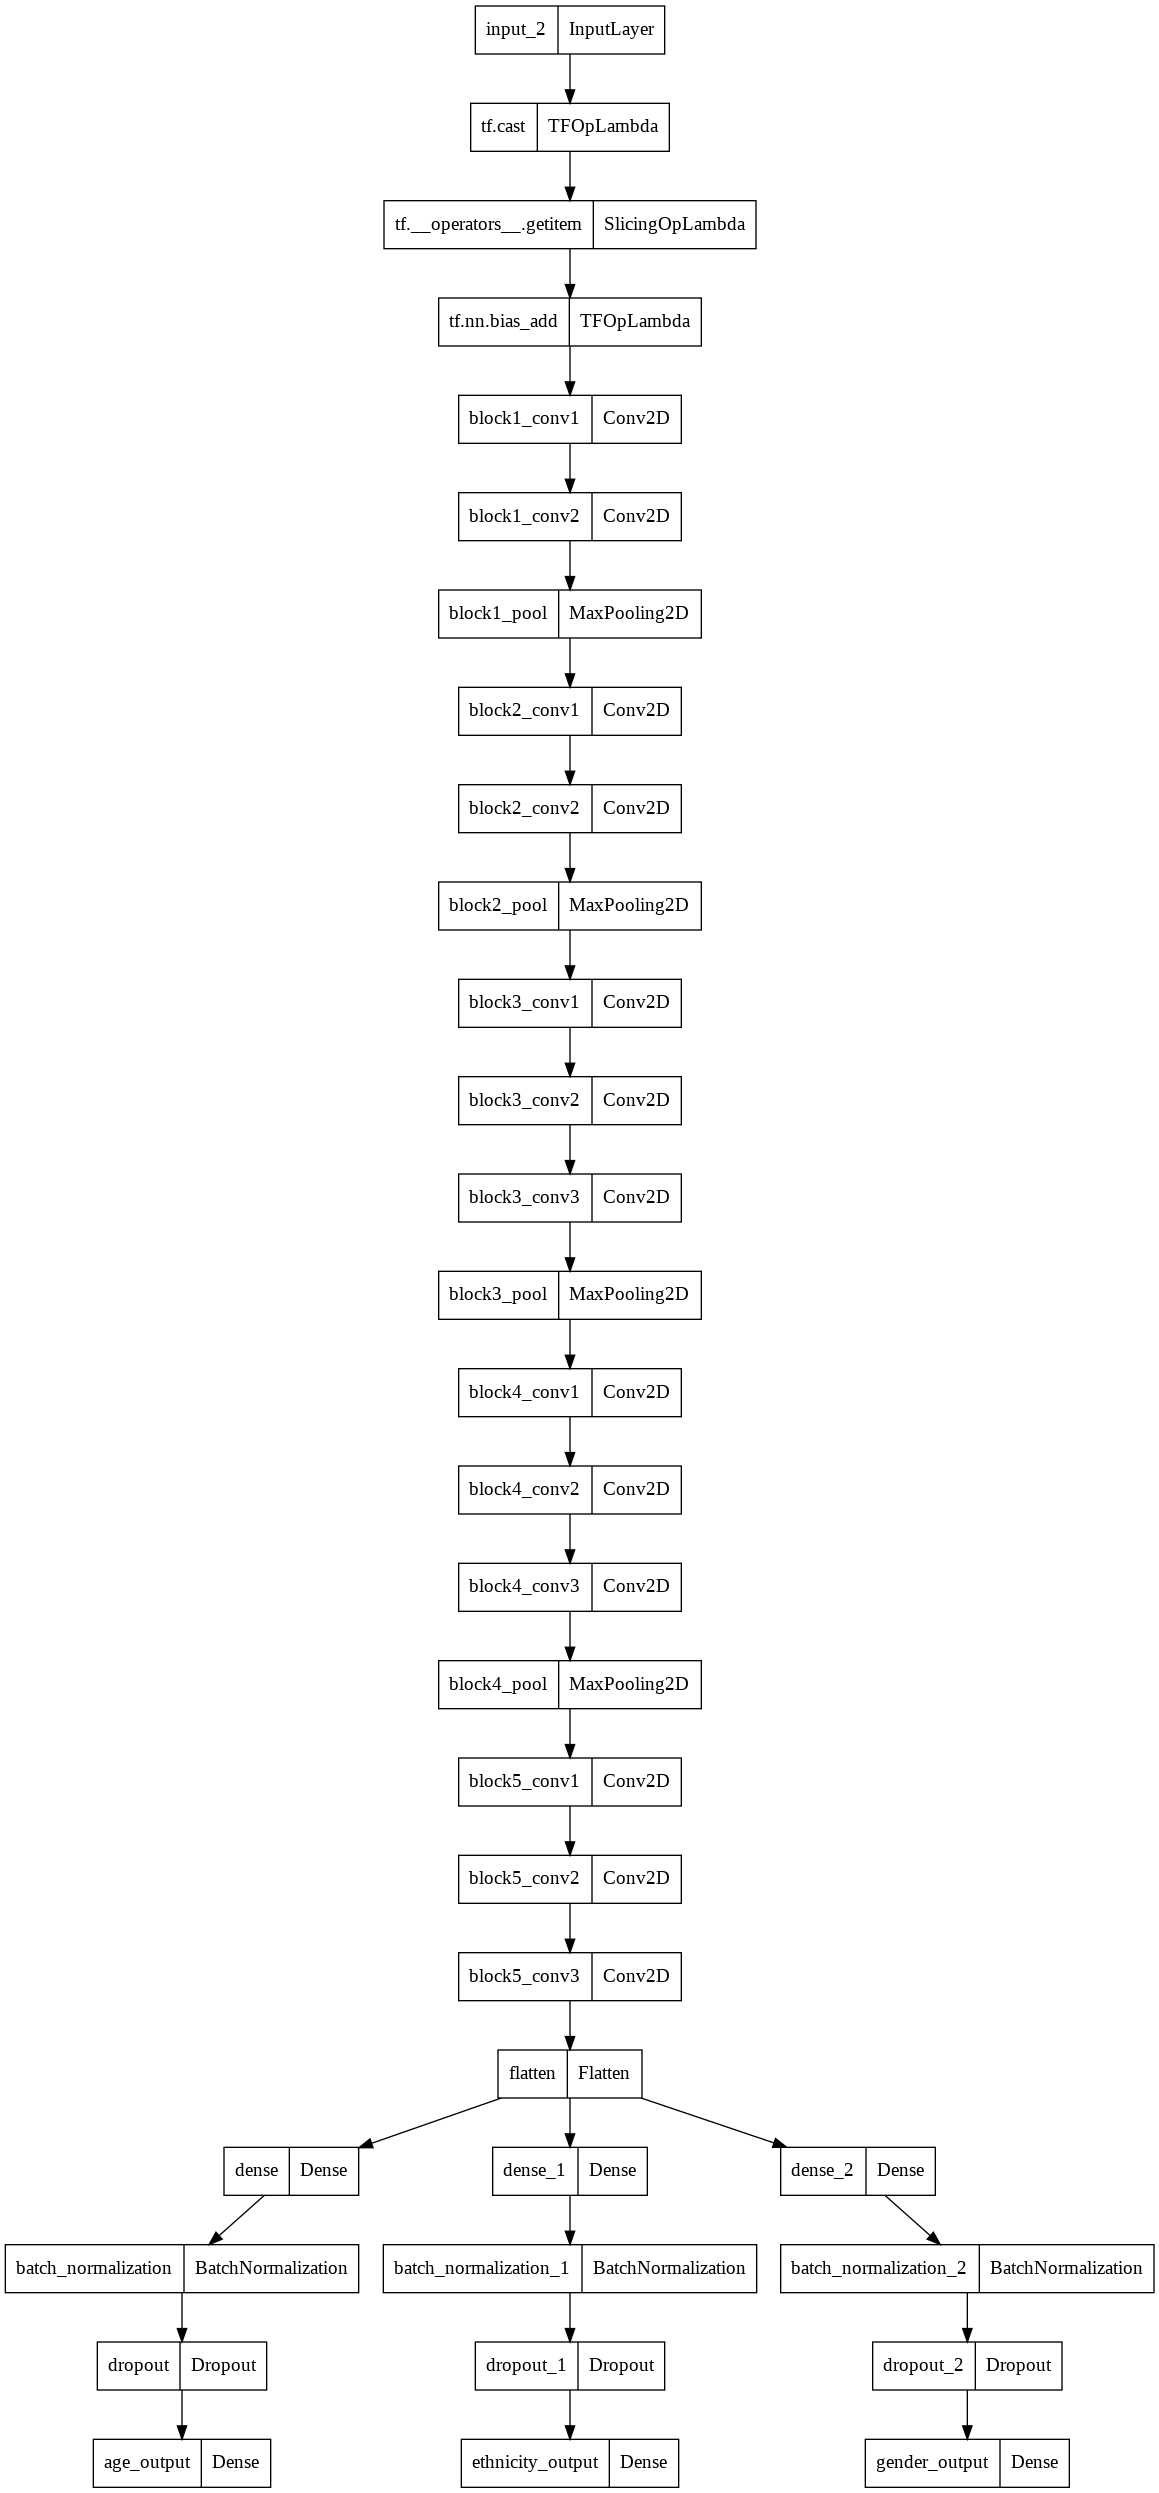

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:

name_genders = ['male', 'female']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


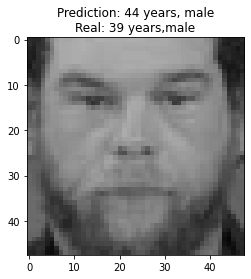

In [ ]:
images, labels = val_dataset[22]
index = 0

p = model.predict(images)

gender_predictions = tf.where(p[2] > 0.5, 1, 0)
plt.title(f'Prediction: {p[0][index].astype(np.int)[0]} years, {name_genders[gender_predictions[index][0]]}\n'+
         f'Real: {int(labels[0][index])} years,{name_genders[int(labels[2][index])]}')
plt.imshow(images[index])
plt.show()